In [8]:
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap


In [2]:
class RuftModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(5, 3)

    def forward(self, x):
        return self.layer(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch  # Corrected to directly unpack the batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch  # Corrected to directly unpack the batch
        y_hat = self(x)
        val_loss = nn.functional.mse_loss(y_hat, y)
        self.log('val_loss', val_loss)
        return val_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [3]:
class CustomDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float)
        self.targets = torch.tensor(targets, dtype=torch.float)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]


In [4]:
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.10,
    patience=3,
    verbose=True,
    mode='min'
)

In [5]:
data = pd.read_csv('data/synthetic_data.csv')  
X = data.iloc[:, :-3].values
y = data.iloc[:, -3:].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [6]:
train_dataset = CustomDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CustomDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [ ]:
model = RuftModel()
trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[early_stop_callback]
)
trainer.fit(model, train_dataloader, val_dataloader)

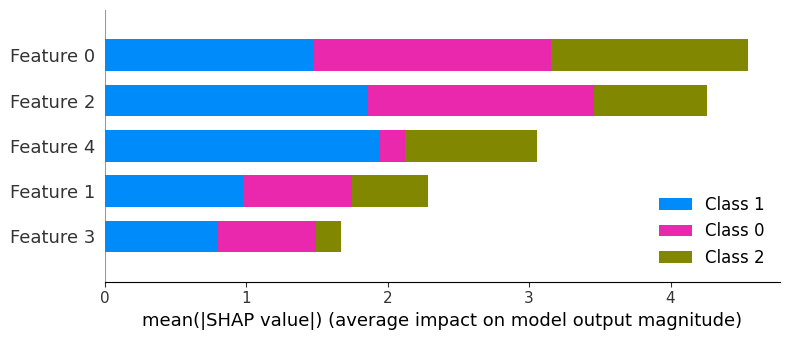

In [9]:
data_for_explanation = next(iter(val_dataloader))
features, _ = data_for_explanation

# Initialize the SHAP explainer
# DeepExplainer works well with deep learning models
explainer = shap.DeepExplainer(model, features)

# Compute SHAP values
shap_values = explainer.shap_values(features)

# Visualizing the SHAP values
# Summarize the effects of all the features
shap.summary_plot(shap_values, features)